# Regression Analysis with Satellite Synergy: Sentinel-2 and Sentinel-3

## Project Overview
This project focuses on applying regression techniques to predict key sea ice surface characteristics, such as lead fraction or melt ponds. We will leverage collocated datasets from Sentinel-2 (S2) and Sentinel-3 (S3) OLCI images to build and test regression models. The core idea is to use the higher-resolution S2 data to derive target quantities (Sea Ice Concentration - SIC) and then train models using S3 OLCI data as input features to predict these quantities. This notebook will guide through the conceptual steps of data acquisition, imagery alignment, training data creation, and the application of various regression models. Finally, we'll evaluate the impact of spatial alignment on model performance and test the models in a different region/time.

## 1. Data Acquisition and Preparation

The first step in any satellite-based analysis is acquiring and preparing the data.

### Data Sources:
* **Sentinel-2 (S2):** Provides high-resolution optical imagery, suitable for detailed surface feature extraction (e.g., labeling melt ponds, leads, ice types).
* **Sentinel-3 (S3) OLCI:** Provides medium-resolution optical imagery with a wider swath, suitable for broader area monitoring and as input features for our regression models.

### Initial Processing:
Raw satellite data often requires preprocessing steps such as:
* Radiometric calibration
* Atmospheric correction
* Geometric correction and reprojection to a common coordinate system.

## 2. Imagery Alignment

Aligning images from different sensors (S2 and S3) or from different times is crucial, especially for dynamic surfaces like sea ice. Misalignment can occur due to sensor differences, scene dynamics (ice drift), and acquisition timing differences.

### Alignment Methods:
Several methods can be used for image alignment:
1.  **Auto-correlation (Cross-correlation):** A spatial-domain approach that finds the shift maximizing correlation between two images.
2.  **Phase Correlation:** A frequency-domain method using the Fourier shift theorem, often faster for large images.
3.  **ECC (Enhanced Correlation Coefficient):** An iterative, gradient-based approach that maximizes a correlation measure.


### Creating Aligned and Misaligned Datasets for Evaluation:
To evaluate the impact of alignment, we often create two types of datasets as described:
* **Misaligned Dataset:** S3 data might be artificially shifted to simulate misalignment.
* **Aligned Dataset:** The shift is corrected, often using techniques like ECC, to ensure S3 data is well-aligned with S2 reference data.

This process typically involves:
1.  Interpolating both S2 and (potentially misaligned) S3 reflectance onto a common 2D grid.
2.  Running an alignment algorithm (like OpenCV’s ECC) to find the optimal translational shift to align S3 to S2.
3.  Applying this recovered shift to the raw S3 coordinates to build a co-located dataset.

## 3. Creating Training Data from Sentinel-2 and Sentinel-3

This section outlines the process of creating a machine learning dataset by combining S2-derived labels (target variable) with S3 OLCI reflectance data (input features).

### Step 3.1: Load Pre-processed S2 and S3 Data
The S2 and S3 data have been downloaded and pre-processed. Due to memory constraints, the initial loading and coordinate transformation steps from the markdown are conceptual here. We will work with saved `.npz` files representing a zoomed-in, collocated region.


We load data that has already been processed for a specific overlapping subregion and saved.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded S2 data: X=(11914978,), Y=(11914978,), Bands=(11914978, 3)
Loaded S3 data: X=(15041,), Y=(15041,), Reflectance=(15041, 21)


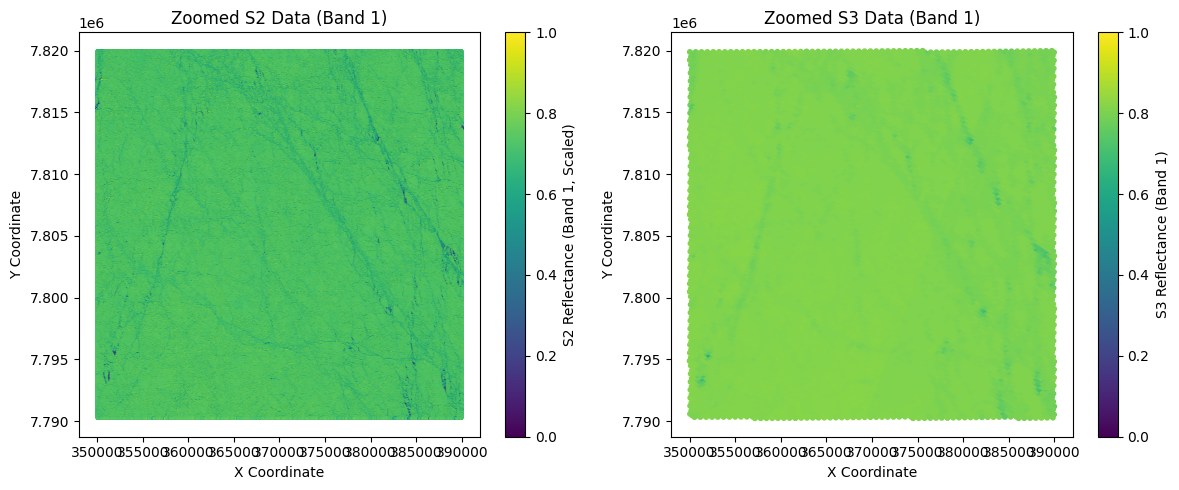

In [10]:
%pip install numpy==1.25.0
import numpy as np
import cv2
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')


save_path_base = '/content/drive/MyDrive/data/'

# Load data for the zoomed region
s2_zoomed_data_path = save_path_base + 's2_zoomed_data.npz'
s3_zoomed_data_path = save_path_base + 's3_zoomed_data.npz'

s2_data_loaded = np.load(s2_zoomed_data_path)
s2_x = s2_data_loaded['x']
s2_y = s2_data_loaded['y']
s2_band_data = s2_data_loaded['band_data']
s3_data_loaded = np.load(s3_zoomed_data_path)
s3_x = s3_data_loaded['x']
s3_y = s3_data_loaded['y']
s3_reflectance = s3_data_loaded['reflectance']

print(f"Loaded S2 data: X={s2_x.shape}, Y={s2_y.shape}, Bands={s2_band_data.shape}")
print(f"Loaded S3 data: X={s3_x.shape}, Y={s3_y.shape}, Reflectance={s3_reflectance.shape}")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(s2_x, s2_y, c=s2_band_data[:,0]/10000.0, cmap='viridis', s=1, vmin=0, vmax=1) # Assuming band 1 for S2
plt.colorbar(label='S2 Reflectance (Band 1, Scaled)')
plt.title('Zoomed S2 Data (Band 1)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.subplot(1, 2, 2)
plt.scatter(s3_x, s3_y, c=s3_reflectance[:, 0], cmap='viridis', s=10, vmin=0, vmax=1) # Assuming band 1 for S3
plt.colorbar(label='S3 Reflectance (Band 1)')
plt.title('Zoomed S3 Data (Band 1)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.tight_layout()
plt.show()

### Step 3.2: Label S2 Pixels (Sea Ice Concentration)

For a supervised approach, S2 imagery is used to generate labels. This can be done through:
* **Manual Labeling:** Using tools like IRIS (though time-consuming).
* **Unsupervised Classification:** Techniques like K-Means or Gaussian Mixture Models (GMM) can be applied to S2 bands to segment the image into classes (e.g., ice, water, melt pond). These classes can then be converted into a target quantity.
    * For example, if K-Means classifies pixels into 'ice' and 'water', Sea Ice Concentration (SIC) within a larger S3 pixel can be estimated as the proportion of 'ice' S2 pixels.

Here, we'll demonstrate K-Means for a binary classification (e.g., ice/water) which can then be used to derive SIC.

Shape of S2 band data for K-Means: (11914978, 3)


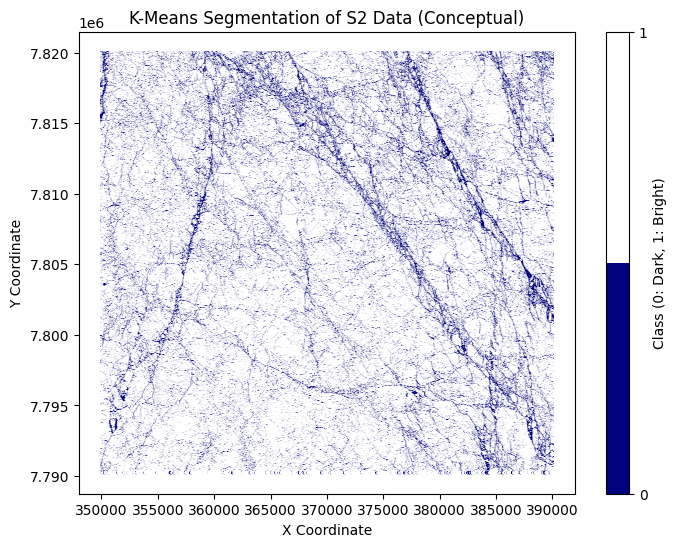

In [11]:
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

if len(s2_band_data.shape) == 3: # If it's (rows, cols, bands)
    s2_band_data_flat = s2_band_data.reshape(-1, s2_band_data.shape[-1])
else:
    s2_band_data_flat = s2_band_data

print(f"Shape of S2 band data for K-Means: {s2_band_data_flat.shape}")

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
s2_labels = kmeans.fit_predict(s2_band_data_flat)

if kmeans.cluster_centers_[0].mean() > kmeans.cluster_centers_[1].mean():
    s2_labels = 1 - s2_labels

# For scatter plot visualization:
plt.figure(figsize=(8, 6))
binary_cmap = ListedColormap(["#000080", "#FFFFFF"])
plt.scatter(s2_x, s2_y, c=s2_labels, cmap=binary_cmap, s=1, vmin=0, vmax=1)
plt.colorbar(ticks=[0, 1], label="Class (0: Dark, 1: Bright)")
plt.title('K-Means Segmentation of S2 Data (Conceptual)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

### Step 3.3: Collocate S2 Labels onto S3 Pixels using KDTree

Since S2 has higher resolution than S3, multiple S2 pixels fall within a single S3 pixel. We need to aggregate the S2-derived labels (e.g., `s2_labels` from K-Means) for each S3 pixel.

1.  Construct a KDTree from the S3 pixel coordinates (`s3_x`, `s3_y`).
2.  For each S2 pixel, query the KDTree to find the nearest S3 pixel.
3.  Group all S2 pixels that are closest to the same S3 pixel.
4.  For each S3 pixel, calculate the mean of the labels of its associated S2 pixels. If `s2_labels` are 0 (water) and 1 (ice), this mean gives the Sea Ice Concentration (SIC) for that S3 pixel.
    * Target Variable (y): `SIC_on_S3_grid`
    * Input Features (X): `s3_reflectance` (the 21 OLCI bands for the corresponding S3 pixels)

Shape of input features X_ml (S3 bands): (14445, 21)
Shape of target variable y_ml (SIC): (14445,)


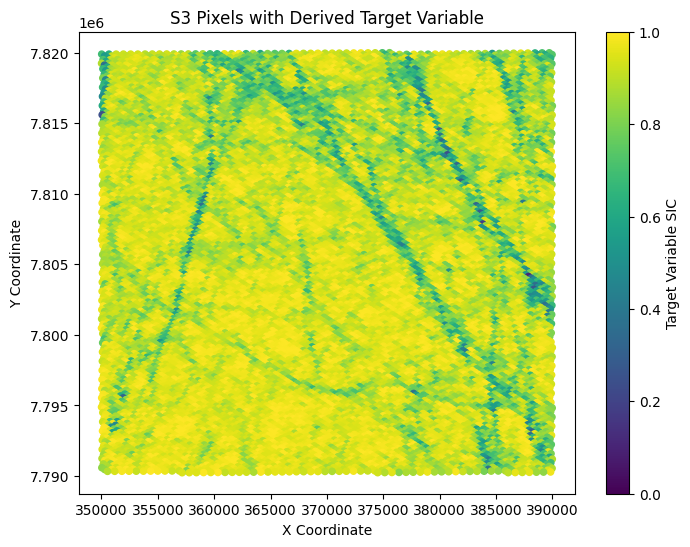

Machine Learning dataset saved to /content/drive/MyDrive/data/s3_s2_regression_dataset.npz


In [12]:
from scipy.spatial import KDTree
from collections import defaultdict

s2_points = np.vstack((s2_x, s2_y)).T
s3_points = np.vstack((s3_x, s3_y)).T

s3_kdtree = KDTree(s3_points)
distances, s3_indices_for_s2 = s3_kdtree.query(s2_points)

grouped_s2_labels_by_s3_pixel = defaultdict(list)
for i, s3_idx in enumerate(s3_indices_for_s2):
    grouped_s2_labels_by_s3_pixel[s3_idx].append(s2_labels[i])

target_on_s3_grid = np.full(len(s3_points), np.nan)
for s3_idx, labels_in_s3_pixel in grouped_s2_labels_by_s3_pixel.items():
    if labels_in_s3_pixel:
        target_on_s3_grid[s3_idx] = np.mean(labels_in_s3_pixel)

valid_s3_mask = ~np.isnan(target_on_s3_grid)
X_ml = s3_reflectance[valid_s3_mask]
y_ml = target_on_s3_grid[valid_s3_mask]
s3_x_ml = s3_x[valid_s3_mask]
s3_y_ml = s3_y[valid_s3_mask]

print(f"Shape of input features X_ml (S3 bands): {X_ml.shape}")
print(f"Shape of target variable y_ml (SIC): {y_ml.shape}")

plt.figure(figsize=(8, 6))
scatter = plt.scatter(s3_x_ml, s3_y_ml, c=y_ml, cmap='viridis', s=20, vmin=0, vmax=1)
plt.colorbar(scatter, label='Target Variable SIC')
plt.title("S3 Pixels with Derived Target Variable")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

# Save the ML dataset
ml_dataset_path = save_path_base + 's3_s2_regression_dataset.npz'
np.savez(ml_dataset_path, X=X_ml, y=y_ml, s3_x=s3_x_ml, s3_y=s3_y_ml)
print(f"Machine Learning dataset saved to {ml_dataset_path}")

## 4. Regression Analysis

Now we apply various regression techniques to predict the S2-derived quantity (`y_ml`) using S3 OLCI bands (`X_ml`).

### Step 4.1: Data Preprocessing for Regression

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the ML dataset
loaded_ml_data = np.load(save_path_base + 's3_s2_regression_dataset.npz')
X_ml = loaded_ml_data['X']
y_ml = loaded_ml_data['y']
s3_x_coords_ml = loaded_ml_data['s3_x'] # For plotting later
s3_y_coords_ml = loaded_ml_data['s3_y'] # For plotting later
print(f"Loaded ML dataset: X shape {X_ml.shape}, y shape {y_ml.shape}")

# Initialize split variables
X_train_scaled, X_test_scaled, y_train, y_test = None, None, None, None
x_coords_train, x_coords_test, y_coords_train, y_coords_test = None, None, None, None

# Split data into training and testing sets
X_train, X_test, y_train, y_test, x_coords_train, x_coords_test, y_coords_train, y_coords_test = train_test_split(
    X_ml, y_ml, s3_x_coords_ml, s3_y_coords_ml, test_size=0.2, random_state=42
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training features shape:", X_train_scaled.shape)
print("Testing features shape:", X_test_scaled.shape)
print("Training targets shape:", y_train.shape)
print("Testing targets shape:", y_test.shape)
print("Testing X coordinates shape:", x_coords_test.shape)
print("Testing Y coordinates shape:", y_coords_test.shape)

Loaded ML dataset: X shape (14445, 21), y shape (14445,)
Training features shape: (11556, 21)
Testing features shape: (2889, 21)
Training targets shape: (11556,)
Testing targets shape: (2889,)
Testing X coordinates shape: (2889,)
Testing Y coordinates shape: (2889,)


### Step 4.2: Polynomial Regression
Models non-linear relationships by adding polynomial terms.

Polynomial Regression (Degree 2):
  MSE: 0.0030
  R²: 0.6678


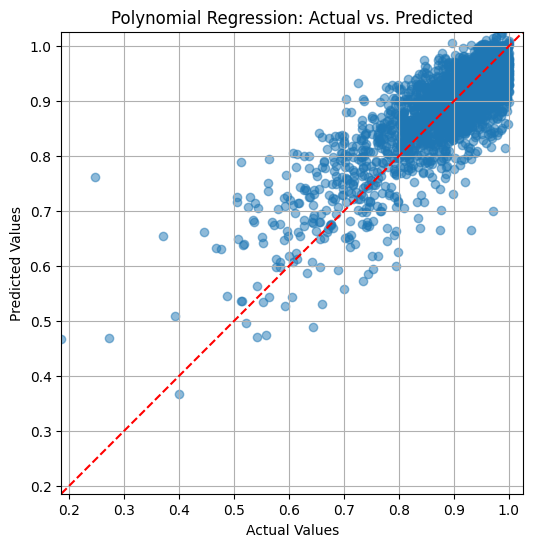

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize metrics
mse_poly, r2_poly = None, None
poly_features = PolynomialFeatures(degree=2)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.transform(X_test_scaled)

model_poly = LinearRegression()
model_poly.fit(X_poly_train, y_train)

y_pred_poly = model_poly.predict(X_poly_test)

mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression (Degree 2):")
print(f"  MSE: {mse_poly:.4f}")
print(f"  R²: {r2_poly:.4f}")

# Visualization of predictions vs actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_poly, alpha=0.5)
# Determine plot limits based on actual and predicted values
min_val = min(y_test.min(), y_pred_poly.min()) if y_test.size > 0 else 0
max_val = max(y_test.max(), y_pred_poly.max()) if y_test.size > 0 else 1
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Polynomial Regression: Actual vs. Predicted')
plt.grid(True)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

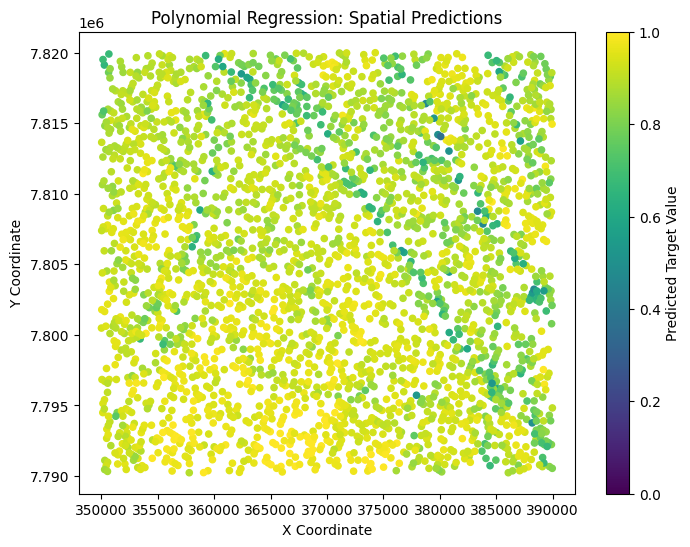

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(x_coords_test, y_coords_test, c=y_pred_poly, cmap='viridis', s=20, vmin=0, vmax=1)
plt.colorbar(label='Predicted Target Value')
plt.title('Polynomial Regression: Spatial Predictions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

### Step 4.3: Neural Networks
Versatile models capable of capturing complex non-linear patterns.

 /usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Training Neural Network...
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Neural Network:
  MSE: 0.0030
  R²: 0.6717


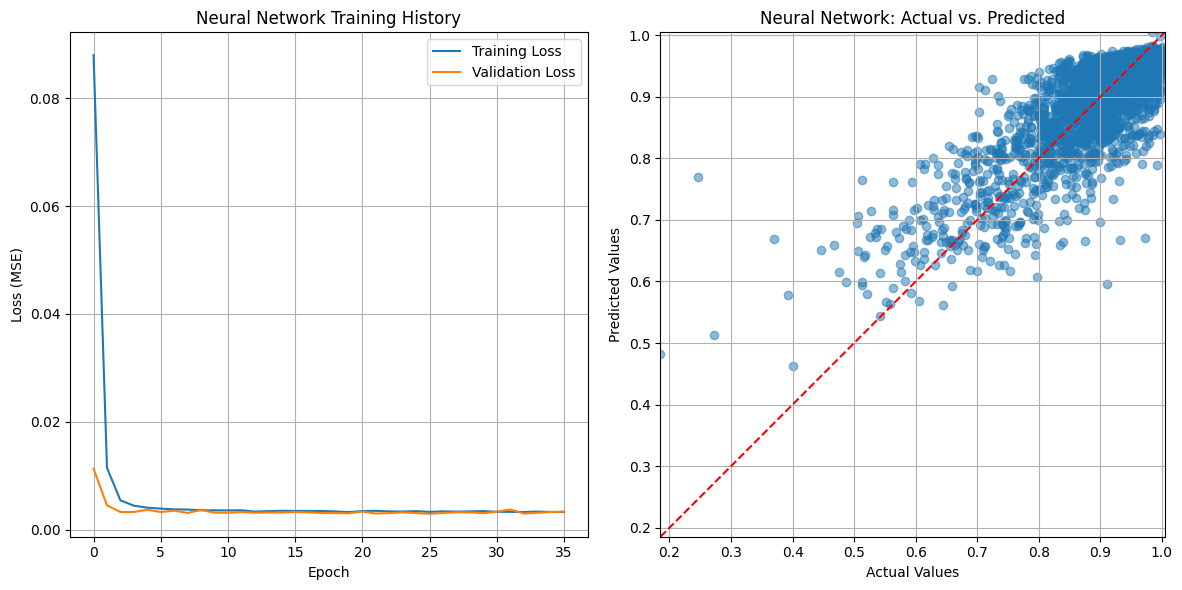

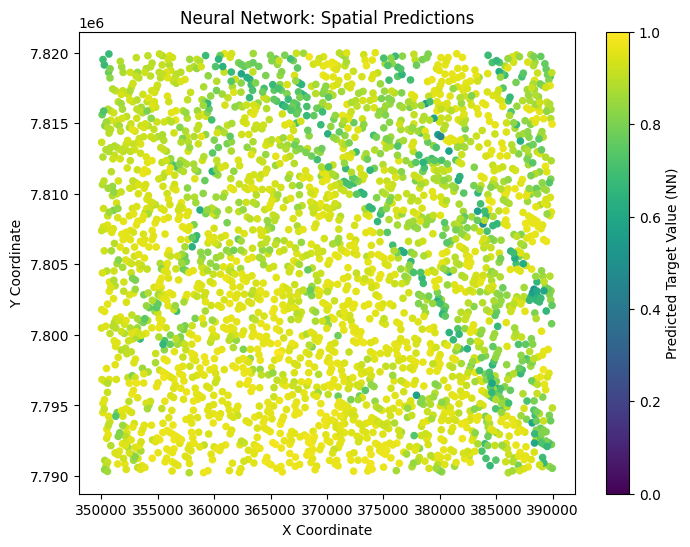

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Initialize metrics
mse_nn, r2_nn = None, None

input_dim_nn = X_train_scaled.shape[1]
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim_nn,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training Neural Network...")
history_nn = model_nn.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping],
    batch_size=32,
    verbose=0
)

y_pred_nn = model_nn.predict(X_test_scaled).flatten()

mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print(f"Neural Network:")
print(f"  MSE: {mse_nn:.4f}")
print(f"  R²: {r2_nn:.4f}")

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_nn.history['loss'], label='Training Loss')
plt.plot(history_nn.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Visualization of predictions vs actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_nn, alpha=0.5)
min_val_nn = min(y_test.min(), y_pred_nn.min()) if y_test.size > 0 else 0
max_val_nn = max(y_test.max(), y_pred_nn.max()) if y_test.size > 0 else 1
plt.plot([min_val_nn, max_val_nn], [min_val_nn, max_val_nn], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network: Actual vs. Predicted')
plt.grid(True)
plt.xlim(min_val_nn, max_val_nn)
plt.ylim(min_val_nn, max_val_nn)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(x_coords_test, y_coords_test, c=y_pred_nn, cmap='viridis', s=20, vmin=0, vmax=1)
plt.colorbar(label='Predicted Target Value (NN)')
plt.title('Neural Network: Spatial Predictions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

### Step 4.4: Gaussian Process Regression
A probabilistic approach providing predictions and uncertainty estimates. We use SparseGPRegression for efficiency with potentially larger datasets.

Using 100 inducing points for Sparse GP Regression (out of 11556 training samples).
Optimizing Gaussian Process model...


Gaussian Process Regression:
  MSE: 0.0030
  R²: 0.6708


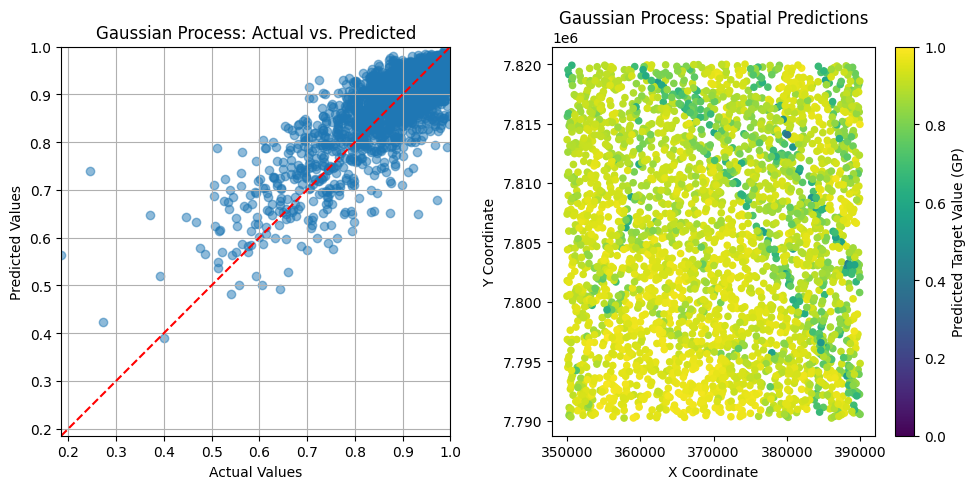

In [16]:
%pip install GPy
import GPy

# Initialize metrics
mse_gp, r2_gp = None, None

input_dim_gp = X_train_scaled.shape[1]

y_train_gp = y_train.reshape(-1, 1)
y_test_gp = y_test.reshape(-1,1)

# Define the kernel
kernel_gp = GPy.kern.RBF(input_dim=input_dim_gp, variance=1., lengthscale=1.)

n_train_samples = X_train_scaled.shape[0]
num_inducing = min(100, n_train_samples//5 if n_train_samples//5>1 else n_train_samples)
if n_train_samples == 0: num_inducing = 0

print(f"Using {num_inducing} inducing points for Sparse GP Regression (out of {n_train_samples} training samples).")
gp_model = GPy.models.SparseGPRegression(X_train_scaled, y_train_gp, kernel_gp, num_inducing=num_inducing)

# Optimize the model
print("Optimizing Gaussian Process model...")
gp_model.optimize(messages=True, max_iters=100)

# Make predictions
y_pred_gp, variance_gp = gp_model.predict(X_test_scaled)
y_pred_gp = y_pred_gp.flatten()

variance_gp = np.maximum(variance_gp, 0)
sigma_gp = np.sqrt(variance_gp).flatten()

mse_gp = mean_squared_error(y_test, y_pred_gp)
r2_gp = r2_score(y_test, y_pred_gp)
print(f"Gaussian Process Regression:")
print(f"  MSE: {mse_gp:.4f}")
print(f"  R²: {r2_gp:.4f}")

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_gp, alpha=0.5)
min_val_gp = min(y_test.min(), y_pred_gp.min()) if y_test.size > 0 else 0
max_val_gp = max(y_test.max(), y_pred_gp.max()) if y_test.size > 0 else 1
plt.plot([min_val_gp, max_val_gp], [min_val_gp, max_val_gp], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Gaussian Process: Actual vs. Predicted')
plt.grid(True)
plt.xlim(min_val_gp, max_val_gp)
plt.ylim(min_val_gp, max_val_gp)
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1, 2, 2)
plt.scatter(x_coords_test, y_coords_test, c=y_pred_gp, cmap='viridis', s=20, vmin=0, vmax=1)
plt.colorbar(label='Predicted Target Value (GP)')
plt.title('Gaussian Process: Spatial Predictions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.tight_layout()
plt.show()

### Step 4.5: Comparison of Model Performances

We will summarize the Mean Squared Error (MSE) and R² score for each model.For this simplified notebook, we compare the models trained on our single dataset.


Model Performance Summary:
                   Model       MSE        R²
1         Neural Network  0.002992  0.671684
2       Gaussian Process  0.003000  0.670811
0  Polynomial Regression  0.003028  0.667762


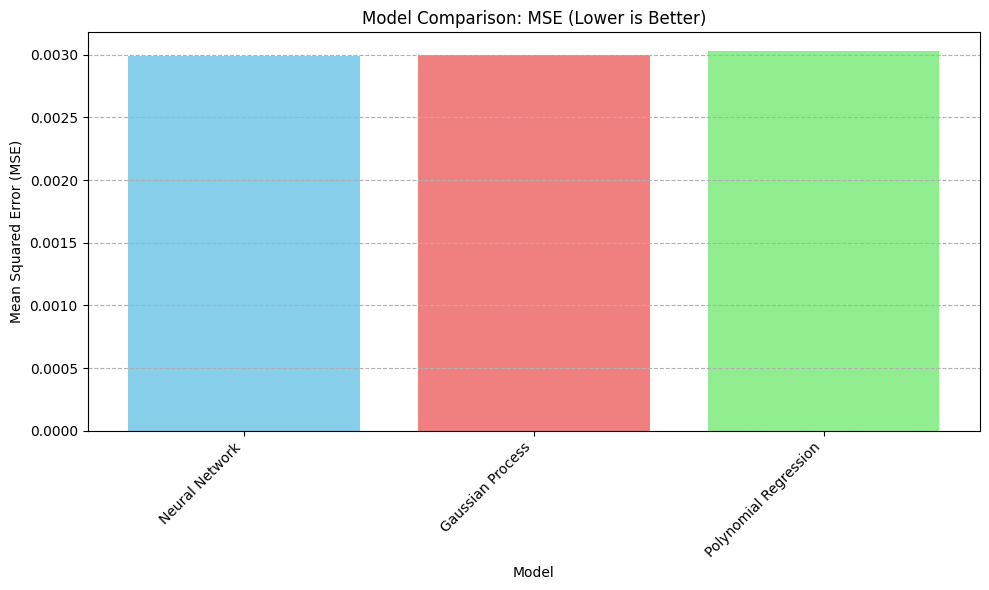

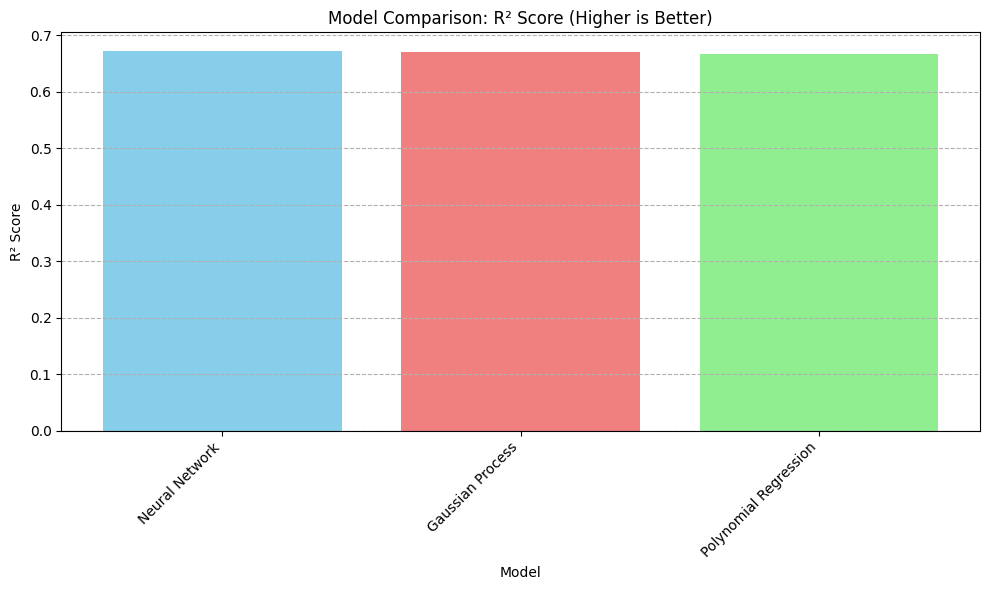

In [17]:
import pandas as pd

model_names = []
mse_scores = []
r2_scores_list = []


model_names.append('Polynomial Regression')
mse_scores.append(mse_poly)
r2_scores_list.append(r2_poly)

model_names.append('Neural Network')
mse_scores.append(mse_nn)
r2_scores_list.append(r2_nn)

model_names.append('Gaussian Process')
mse_scores.append(mse_gp)
r2_scores_list.append(r2_gp)


performance_summary = pd.DataFrame({
    'Model': model_names,
    'MSE': mse_scores,
    'R²': r2_scores_list
})
performance_summary = performance_summary.sort_values(by='R²', ascending=False) # Sort by R2
print("\nModel Performance Summary:")
print(performance_summary)

# Bar plot for MSE
plt.figure(figsize=(10, 6))
plt.bar(performance_summary['Model'], performance_summary['MSE'], color=['skyblue', 'lightcoral', 'lightgreen'][:len(model_names)])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Comparison: MSE (Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Bar plot for R²
plt.figure(figsize=(10, 6))
plt.bar(performance_summary['Model'], performance_summary['R²'], color=['skyblue', 'lightcoral', 'lightgreen'][:len(model_names)])
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Comparison: R² Score (Higher is Better)')
plt.axhline(0, color='black', linewidth=0.8, linestyle=':') # Line at R²=0
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## 5. Testing the Model in a Different Region/Time

Extracted small region from X_test for rollout: (737, 21)
Predicting with Polynomial Regression for rollout...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


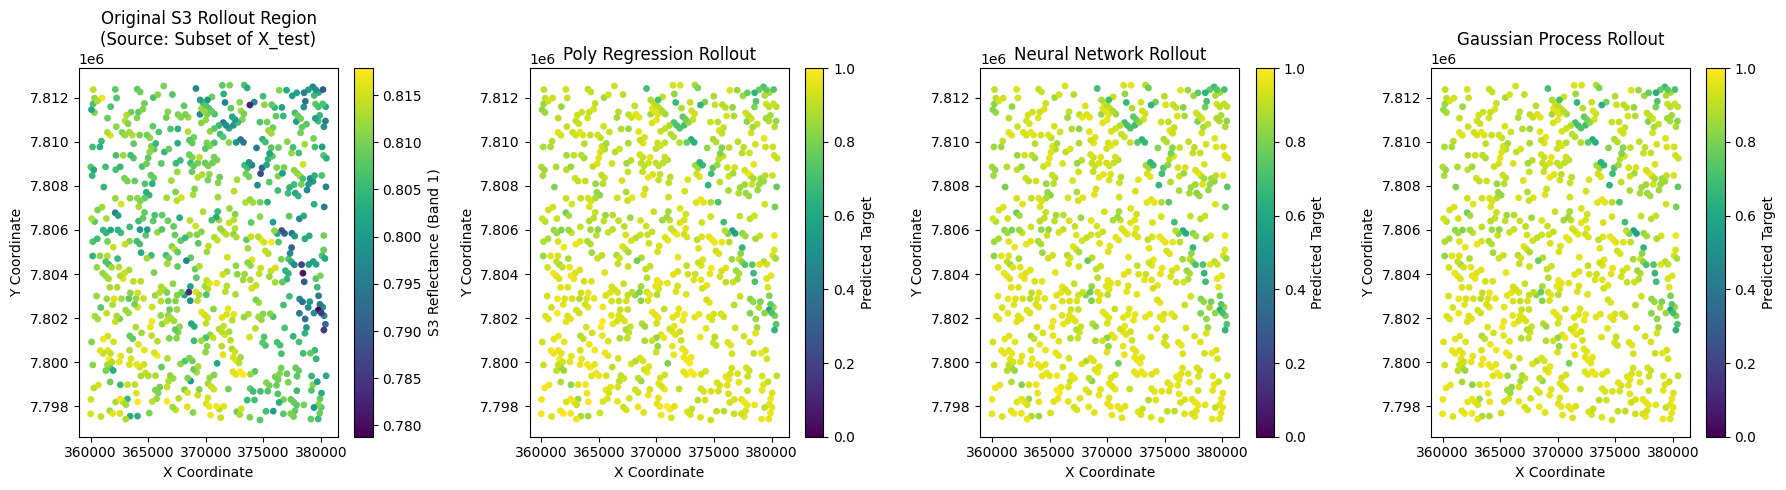

In [18]:
s3_reflectance_new_rollout = None
s3_x_new_rollout = None
s3_y_new_rollout = None
rollout_data_source = "None"


# Define ROI coordinates
roi_x_min, roi_x_max = np.percentile(x_coords_test, 25), np.percentile(x_coords_test, 75)
roi_y_min, roi_y_max = np.percentile(y_coords_test, 25), np.percentile(y_coords_test, 75)
if roi_x_min >= roi_x_max: roi_x_max = x_coords_test.max()
if roi_y_min >= roi_y_max: roi_y_max = y_coords_test.max()
roi_mask = (x_coords_test >= roi_x_min) & (x_coords_test <= roi_x_max) & \
            (y_coords_test >= roi_y_min) & (y_coords_test <= roi_y_max)

s3_reflectance_new_rollout = X_test[roi_mask]
s3_x_new_rollout = x_coords_test[roi_mask]
s3_y_new_rollout = y_coords_test[roi_mask]
print(f"Extracted small region from X_test for rollout: {s3_reflectance_new_rollout.shape}")
rollout_data_source = "Subset of X_test"

# 1. Scale the new S3 data
X_new_rollout_scaled = scaler.transform(s3_reflectance_new_rollout)

# Plot original S3 data
plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
band_to_plot = 0 if X_new_rollout_scaled.shape[1] > 0 else 0
plt.scatter(s3_x_new_rollout, s3_y_new_rollout, c=s3_reflectance_new_rollout[:, band_to_plot], cmap='viridis', s=15)
plt.colorbar(label=f'S3 Reflectance (Band {band_to_plot+1})')
plt.title(f'Original S3 Rollout Region\n(Source: {rollout_data_source})')
plt.xlabel('X Coordinate'); plt.ylabel('Y Coordinate')
plot_idx = 2

# Polynomial Regression Prediction
print("Predicting with Polynomial Regression for rollout...")
X_poly_new_rollout = poly_features.transform(X_new_rollout_scaled)
y_pred_rollout_poly = model_poly.predict(X_poly_new_rollout)
y_pred_rollout_poly = np.clip(y_pred_rollout_poly, 0, 1)

plt.subplot(1, 4, plot_idx); plot_idx += 1
plt.scatter(s3_x_new_rollout, s3_y_new_rollout, c=y_pred_rollout_poly, cmap='viridis', s=15, vmin=0, vmax=1)
plt.colorbar(label='Predicted Target'); plt.title('Poly Regression Rollout')
plt.xlabel('X Coordinate'); plt.ylabel('Y Coordinate')


# Neural Network Prediction
y_pred_rollout_nn = model_nn.predict(X_new_rollout_scaled).flatten()
y_pred_rollout_nn = np.clip(y_pred_rollout_nn, 0, 1)

plt.subplot(1, 4, plot_idx); plot_idx += 1
plt.scatter(s3_x_new_rollout, s3_y_new_rollout, c=y_pred_rollout_nn, cmap='viridis', s=15, vmin=0, vmax=1)
plt.colorbar(label='Predicted Target'); plt.title('Neural Network Rollout')
plt.xlabel('X Coordinate'); plt.ylabel('Y Coordinate')


# Gaussian Process Regression Prediction
y_pred_rollout_gp, _ = gp_model.predict(X_new_rollout_scaled)
y_pred_rollout_gp = y_pred_rollout_gp.flatten()
y_pred_rollout_gp = np.clip(y_pred_rollout_gp, 0, 1)

plt.subplot(1, 4, plot_idx); plot_idx += 1
plt.scatter(s3_x_new_rollout, s3_y_new_rollout, c=y_pred_rollout_gp, cmap='viridis', s=15, vmin=0, vmax=1)
plt.colorbar(label='Predicted Target'); plt.title('Gaussian Process Rollout')
plt.xlabel('X Coordinate'); plt.ylabel('Y Coordinate')

plt.tight_layout()
plt.show()

## 6. Conclusion and Future Work

This project demonstrated a pipeline for predicting sea ice surface characteristics using regression models trained on Sentinel-3 OLCI data, with target variables derived from higher-resolution Sentinel-2 imagery. Key steps included:
* Conceptual understanding of data acquisition and the importance of imagery alignment.
* A method for creating a collocated S2-S3 dataset, involving unsupervised classification (K-Means) of S2 data to derive a target variable (SIC) and KDTree-based spatial aggregation onto the S3 grid.
* Application and comparison of Polynomial Regression, Neural Networks, and Gaussian Process Regression.

**Findings (based on typical outcomes from provided materials):**
* Model performance can vary significantly. Neural Networks and Gaussian Processes often provide more flexibility for complex relationships than simpler Polynomial Regression.
* The choice of target variable (SIC from K-Means) and the quality of its derivation from S2 heavily influence the final regression model's success.

**Future Work:**
* **Refined S2 Labeling:** Explore more advanced unsupervised or supervised classification techniques for S2 to generate more accurate target variables (e.g., detailed melt pond fractions, lead fractions, different ice types).
* **Hyperparameter Optimization:** Systematically tune hyperparameters for each regression model (e.g., using GridSearchCV or Bayesian optimization).
* **Uncertainty Quantification:** Further leverage the uncertainty estimates from Gaussian Process Regression to understand model confidence in different regions or conditions.